In [2]:
import requests
import pandas as pd

# Replace with your Alpha Vantage API key
API_KEY = "QS9EE8OCDE2GZ65N"

def fetch_stock_data(symbol, interval="5min"):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={API_KEY}&outputsize=full"

    response = requests.get(url)
    data = response.json()

    # Find the correct key dynamically
    time_series_key = None
    for key in data.keys():
        if "Time Series" in key:
            time_series_key = key
            break

    if not time_series_key:
        print("Error: No time series data found")
        return None

    # Convert to DataFrame
    df = pd.DataFrame.from_dict(data[time_series_key], orient="index")

    # Rename columns
    df = df.rename(columns={
        "1. open": "Open",
        "2. high": "High",
        "3. low": "Low",
        "4. close": "Close",
        "5. volume": "Volume"
    })

    df.index = pd.to_datetime(df.index)  # Convert index to datetime
    df = df.sort_index()  # Ensure chronological order
    df = df[["Close"]].astype(float)  # Keep only closing price and convert to float

    return df

# Example usage
symbol = "IBM"  # Example stock; use "WTI" for crude oil
df = fetch_stock_data(symbol)

if df is not None:
    print(df.head())  # Print first few rows


                      Close
2025-03-03 04:00:00  252.42
2025-03-03 04:05:00  252.43
2025-03-03 04:15:00  252.43
2025-03-03 04:20:00  252.44
2025-03-03 04:25:00  252.12


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, time_steps=50):
    df_scaled = scaler.fit_transform(df)  # Normalize between 0 and 1
    
    X, y = [], []
    for i in range(len(df_scaled) - time_steps):
        X.append(df_scaled[i:i+time_steps])  # Take 'time_steps' past records
        y.append(df_scaled[i+time_steps])  # Predict the next value
    
    X, y = np.array(X), np.array(y)
    
    # Split into 80% train and 20% test
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    return X_train, X_test, y_train, y_test

# Convert the fetched data into training format
X_train, X_test, y_train, y_test = preprocess_data(df)

# Check dataset shapes
print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, {y_test.shape}")


Training Data Shape: (2889, 50, 1), (2889, 1)
Testing Data Shape: (723, 50, 1), (723, 1)


Epoch 1/50


/Users/shreyankanaik/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0348 - val_loss: 0.0019
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - val_loss: 9.9737e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - val_loss: 9.7372e-04
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0017 - val_loss: 9.7047e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - val_loss: 8.0726e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - val_loss: 7.5019e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - val_loss: 7.0395e-04
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - val_loss: 7.3990e-04
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 7.8025e-04
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 

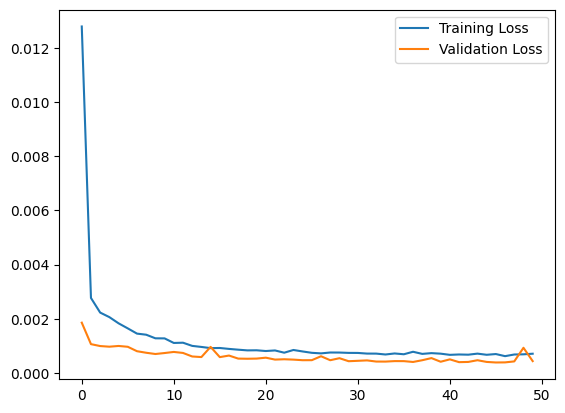

Model: LSTM
Training Loss: 0.0007145770941860974
Validation Loss: 0.00044218936818651855


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)  # Predict single value (future price)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and train the LSTM model
lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

train_loss = history.history['loss'][-1]  # Last training loss
val_loss = history.history['val_loss'][-1]  # Last validation loss

print(f"Model: LSTM")  # Change XYZ to LSTM, CNN, etc.
print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")



Epoch 1/50


/Users/shreyankanaik/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0203 - val_loss: 7.7870e-04
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.0037 - val_loss: 7.0564e-04
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.0033 - val_loss: 5.8633e-04
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0029 - val_loss: 5.2235e-04
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0029 - val_loss: 5.4993e-04
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.0024 - val_loss: 9.4928e-04
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.0024 - val_loss: 4.6866e-04
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 0.0018 - val_loss: 7.0532e-04
Epoch 9/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 0.0022 - val_loss: 4.1797e-04
Epoch 10/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.0014 - val_loss: 4.1783e-04
Epoch 11/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0015 - val_loss: 4.9650e-04

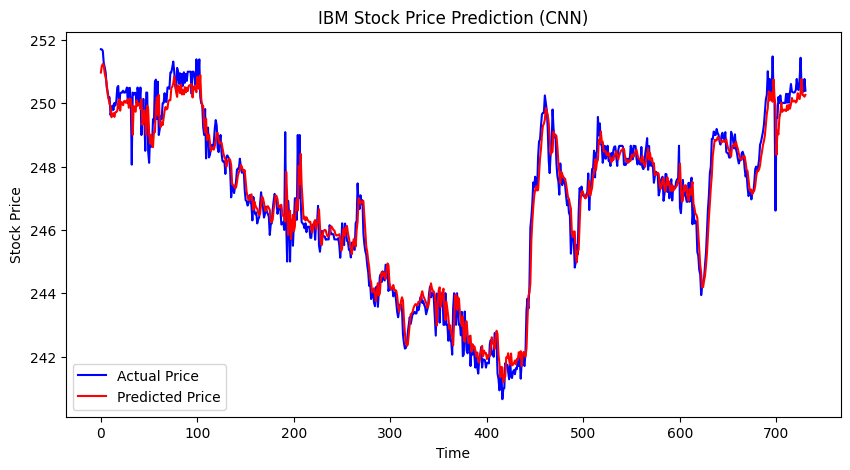

Model: CNN
Training Loss: 0.0009078595321625471
Validation Loss: 0.0003988157259300351


In [5]:
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Alpha Vantage API Key (Replace with your own)
API_KEY = "QS9EE8OCDE2GZ65N"

# Function to fetch real-time stock data
def fetch_stock_data(symbol, interval="5min"):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={API_KEY}&outputsize=full"
    response = requests.get(url)
    data = response.json()

    # Find the correct key dynamically
    time_series_key = None
    for key in data.keys():
        if "Time Series" in key:
            time_series_key = key
            break

    if not time_series_key:
        print("Error: No time series data found")
        return None

    # Convert to DataFrame
    df = pd.DataFrame.from_dict(data[time_series_key], orient="index")

    # Rename columns
    df = df.rename(columns={
        "1. open": "Open",
        "2. high": "High",
        "3. low": "Low",
        "4. close": "Close",
        "5. volume": "Volume"
    })

    df.index = pd.to_datetime(df.index)  # Convert index to datetime
    df = df.sort_index()  # Ensure chronological order
    df = df[["Close"]].astype(float)  # Keep only closing price and convert to float

    return df

# Fetch IBM stock data
stock_symbol = "IBM"
df = fetch_stock_data(stock_symbol)

if df is None or df.empty:
    raise ValueError("Failed to fetch data. Check API limits or symbol.")

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Prepare sequences for CNN
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Using past 10 timestamps
X, y = create_sequences(df_scaled, seq_length)

# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape for CNN input (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # 1 feature (Close price)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Predict single stock price
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

# Evaluate Model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict future stock prices
predictions = model.predict(X_test)

# Convert back to original price scale
predictions = scaler.inverse_transform(predictions)

# Print predictions
print("Predicted IBM Stock Prices:")
print(predictions[:5])


import matplotlib.pyplot as plt

# Convert actual prices back to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label="Actual Price", color='blue')
plt.plot(predictions, label="Predicted Price", color='red')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("IBM Stock Price Prediction (CNN)")
plt.legend()
plt.show()


train_loss = history.history['loss'][-1]  # Last training loss
val_loss = history.history['val_loss'][-1]  # Last validation loss

print(f"Model: CNN")  # Change XYZ to LSTM, CNN, etc.
print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")


Epoch 1/50


/Users/shreyankanaik/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0346 - val_loss: 0.0016
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - val_loss: 8.9055e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 7.3238e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0015 - val_loss: 7.1460e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0013 - val_loss: 5.7398e-04
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0012 - val_loss: 5.1927e-04
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.6349e-04 - val_loss: 6.2083e-04
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms

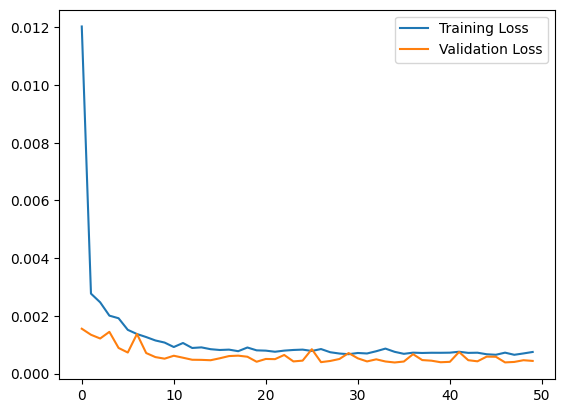

Model: Hybrid
Training Loss: 0.0007514716708101332
Validation Loss: 0.0004416429146658629


In [6]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, Reshape
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Replace with your Alpha Vantage API key
API_KEY = "QS9EE8OCDE2GZ65N"

def fetch_stock_data(symbol, interval="5min"):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={API_KEY}&outputsize=full"
    response = requests.get(url)
    data = response.json()

    # Find the correct key dynamically
    time_series_key = None
    for key in data.keys():
        if "Time Series" in key:
            time_series_key = key
            break

    if not time_series_key:
        print("Error: No time series data found")
        return None

    df = pd.DataFrame.from_dict(data[time_series_key], orient="index")
    df = df.rename(columns={
        "1. open": "Open", "2. high": "High", "3. low": "Low", "4. close": "Close", "5. volume": "Volume"
    })
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df[["Close"]].astype(float)
    return df

# Fetch stock data
symbol = "IBM"  # Example stock
df = fetch_stock_data(symbol)
if df is None:
    raise ValueError("Stock data fetching failed. Check API response.")

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, time_steps=50):
    df_scaled = scaler.fit_transform(df)
    X, y = [], []
    for i in range(len(df_scaled) - time_steps):
        X.append(df_scaled[i:i+time_steps])
        y.append(df_scaled[i+time_steps])
    
    X, y = np.array(X), np.array(y)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(df)

# Build Hybrid LSTM + CNN model
def build_hybrid_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the hybrid model
hybrid_model = build_hybrid_model((X_train.shape[1], X_train.shape[2]))
history = hybrid_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

train_loss = history.history['loss'][-1]  # Last training loss
val_loss = history.history['val_loss'][-1]  # Last validation loss

print(f"Model: Hybrid")  # Change XYZ to LSTM, CNN, etc.
print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.1223 - val_loss: 0.0100
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0165 - val_loss: 0.0051
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0119 - val_loss: 0.0032
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0087 - val_loss: 0.0029
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0077 - val_loss: 0.0030
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0075 - val_loss: 0.0030
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0073 - val_loss: 0.0032
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0071 - val_loss: 0.0037
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0070 - val_loss: 0.0028
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0

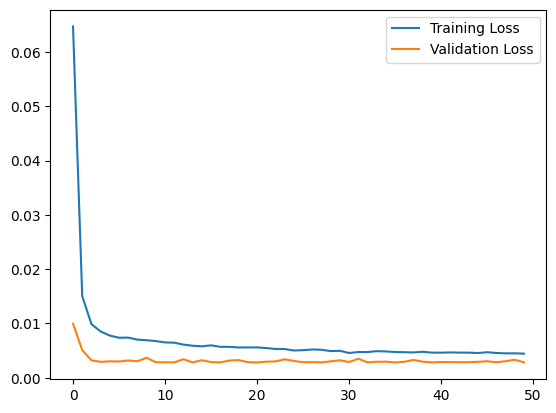

Model: Transformer
Training Loss: 0.004442259669303894
Validation Loss: 0.002843429334461689


In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler

# Alpha Vantage API Key
API_KEY = "QS9EE8OCDE2GZ65N"

def fetch_stock_data(symbol, interval="5min"):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={API_KEY}&outputsize=full"
    response = requests.get(url)
    data = response.json()

    # Find the correct key dynamically
    time_series_key = next((key for key in data if "Time Series" in key), None)
    if not time_series_key:
        print("Error: No time series data found")
        return None

    df = pd.DataFrame.from_dict(data[time_series_key], orient="index")
    df = df.rename(columns={"1. open": "Open", "2. high": "High", "3. low": "Low", "4. close": "Close", "5. volume": "Volume"})
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df[["Close"]].astype(float)
    return df

# Fetch stock data
symbol = "IBM"
df = fetch_stock_data(symbol)
if df is None:
    raise ValueError("Stock data fetching failed. Check API response.")

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, time_steps=50):
    df_scaled = scaler.fit_transform(df)
    X, y = [], []
    for i in range(len(df_scaled) - time_steps):
        X.append(df_scaled[i:i+time_steps])
        y.append(df_scaled[i+time_steps])
    
    X, y = np.array(X), np.array(y)
    split = int(len(X) * 0.8)
    return X[:split], X[split:], y[:split], y[split:]

X_train, X_test, y_train, y_test = preprocess_data(df)

# Positional Encoding (Needed for Time Series)
def positional_encoding(seq_length, d_model):
    positions = np.arange(seq_length)[:, np.newaxis]
    div_terms = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_enc = np.zeros((seq_length, d_model))
    pos_enc[:, 0::2] = np.sin(positions * div_terms)
    pos_enc[:, 1::2] = np.cos(positions * div_terms)
    return tf.constant(pos_enc, dtype=tf.float32)

# Transformer Encoder Block
def transformer_encoder(inputs, head_size=128, num_heads=4, ff_dim=128, dropout=0.2):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs  # Residual Connection

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res  # Final residual connection

# Define Transformer Model
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    pos_encoding = positional_encoding(input_shape[0], input_shape[1])
    x = inputs + pos_encoding  # Adding positional encoding

    x = transformer_encoder(x)
    x = transformer_encoder(x)
    x = transformer_encoder(x)
    
    x = GlobalAveragePooling1D()(x)  # Convert sequence to single value
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the Transformer Model
transformer_model = build_transformer_model((X_train.shape[1], X_train.shape[2]))
history = transformer_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

train_loss = history.history['loss'][-1]  # Last training loss
val_loss = history.history['val_loss'][-1]  # Last validation loss

print(f"Model: Transformer")  # Change XYZ to LSTM, CNN, etc.
print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)  # Get predictions
    predictions = scaler.inverse_transform(predictions)  # Convert back to actual prices
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Ensure correct shape

    mse = mean_squared_error(y_test_actual, predictions)
    mae = mean_absolute_error(y_test_actual, predictions)

    print(f"🔹 {model_name} Performance:")
    print(f"✅ Mean Squared Error (MSE): {mse:.4f}")
    print(f"✅ Mean Absolute Error (MAE): {mae:.4f}")
    print("-" * 50)

    return mse, mae, predictions, y_test_actual

# Evaluate all models
mse_lstm, mae_lstm, pred_lstm, actual_values = evaluate_model(lstm_model, X_test, y_test, "LSTM")
# mse_cnn, mae_cnn, pred_cnn, _ = evaluate_model(cnn_model, X_test, y_test, "CNN")
mse_hybrid, mae_hybrid, pred_hybrid, _ = evaluate_model(hybrid_model, X_test, y_test, "Hybrid (LSTM + CNN)")
mse_transformer, mae_transformer, pred_transformer, _ = evaluate_model(transformer_model, X_test, y_test, "Transformer")

# Print all results in one place
print("\n📊 **Final Model Comparisons:**")
print(f"LSTM       - MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}")
# print(f"CNN        - MSE: {mse_cnn:.4f}, MAE: {mae_cnn:.4f}")
print(f"Hybrid     - MSE: {mse_hybrid:.4f}, MAE: {mae_hybrid:.4f}")
print(f"Transformer - MSE: {mse_transformer:.4f}, MAE: {mae_transformer:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
🔹 LSTM Performance:
✅ Mean Squared Error (MSE): 0.3276
✅ Mean Absolute Error (MAE): 0.4258
--------------------------------------------------
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
🔹 Hybrid (LSTM + CNN) Performance:
✅ Mean Squared Error (MSE): 0.3272
✅ Mean Absolute Error (MAE): 0.4187
--------------------------------------------------
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
🔹 Transformer Performance:
✅ Mean Squared Error (MSE): 2.1064
✅ Mean Absolute Error (MAE): 1.1040
--------------------------------------------------

📊 **Final Model Comparisons:**
LSTM       - MSE: 0.3276, MAE: 0.4258
Hybrid     - MSE: 0.3272, MAE: 0.4187
Transformer - MSE: 2.1064, MAE: 1.1040


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Model Evaluation:
✅ Mean Squared Error (MSE): 0.3276
✅ Mean Absolute Error (MAE): 0.4258


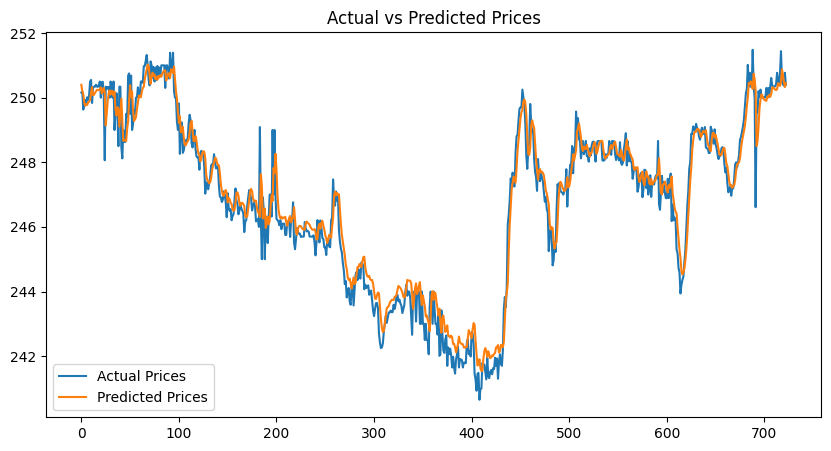

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Predicted Future Prices:
2025-04-02 09:16 -> $250.39


/Users/shreyankanaik/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model
from datetime import datetime, timedelta

# Evaluate Model Performance
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test)

    mse = mean_squared_error(y_test_actual, predictions)
    mae = mean_absolute_error(y_test_actual, predictions)

    print(f"\nModel Evaluation:")
    print(f"✅ Mean Squared Error (MSE): {mse:.4f}")
    print(f"✅ Mean Absolute Error (MAE): {mae:.4f}")
    return mse, mae, predictions, y_test_actual

mse, mae, pred, actual = evaluate_model(lstm_model, X_test, y_test)

# Plot Actual vs Predicted Prices
plt.figure(figsize=(10,5))
plt.plot(actual, label='Actual Prices')
plt.plot(pred, label='Predicted Prices')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.show()

# Function to Predict Future Price
def predict_future_price(future_date, model, df, seq_length=50):
    last_sequence = df[-seq_length:].values.reshape(-1, 1)
    last_sequence = scaler.transform(last_sequence)  # Normalize data
    last_sequence = np.array([last_sequence])  # Reshape for LSTM

    future_predictions = []
    current_date = datetime.now()
    
    while current_date < future_date:
        predicted_price = model.predict(last_sequence)[0][0]
        predicted_price_actual = scaler.inverse_transform([[predicted_price]])[0][0]
        
        future_predictions.append((current_date.strftime('%Y-%m-%d %H:%M'), predicted_price_actual))
        
        # Update sequence (shift left, add new prediction)
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = predicted_price
        
        current_date += timedelta(days=1)  # Adjust for daily predictions
    
    print("\nPredicted Future Prices:")
    for date, price in future_predictions:
        print(f"{date} -> ${price:.2f}")

# Get User Input
date_input = input("Enter future date (YYYY-MM-DD): ")
future_date = datetime.strptime(date_input, "%Y-%m-%d")

predict_future_price(future_date, lstm_model, df)
